In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from sklearn import preprocessing, decomposition, model_selection, linear_model, metrics, ensemble, svm, utils
from sklearn.datasets import make_classification
import gc
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import metrics
import sklearn
import itertools

In [2]:
# Get the data
transactions = pd.read_csv('data/transactions.csv')
identities = pd.read_csv('data/identities.csv')

In [3]:
# Join datasets
dataset = transactions.merge(identities, how='left', left_index=True, right_index=True)

In [4]:
# Reduce memory usage
def reduce_mem(df):
  start_mem=df.memory_usage().sum()/1024**2
  print('Initial Memory Usage : {:.2f} MB'.format(start_mem))
  for col in df.columns:
    col_type=df[col].dtype
    if col_type != object:
      mn, mx = df[col].min(), df[col].max()
      if str(col_type)[:3]=='int':
        if mn>np.iinfo(np.int8).min and mx<np.iinfo(np.int8).max:
          df[col]=df[col].astype(np.int8)
        elif mn>np.iinfo(np.int16).min and mx<np.iinfo(np.int16).max:
          df[col]=df[col].astype(np.int16)
        elif mn>np.iinfo(np.int32).min and mx<np.iinfo(np.int32).max:
          df[col]=df[col].astype(np.int32)
      else:
        if mn>np.finfo(np.float16).min and mx<np.finfo(np.float16).max:
          df[col]=df[col].astype(np.float16)
        elif mn>np.finfo(np.float32).min and mx<np.finfo(np.float32).max:
          df[col]=df[col].astype(np.float32)
  end_mem = df.memory_usage().sum()/1024**2
  print('Final Memory Usage : {:.2f} MB'.format(end_mem))
  print('Decreased by {:.2f}%'.format(100*(start_mem-end_mem)/start_mem))
  return df

In [5]:
dataset = reduce_mem(dataset)

Initial Memory Usage : 1959.88 MB
Final Memory Usage : 648.22 MB
Decreased by 66.93%


In [6]:
del transactions, identities
gc.collect()

56

Notice that the dataset is imbalanced. Non-fraudulent transactions are a minority.


([<matplotlib.patches.Wedge at 0x1a35defb70>,
 [Text(-1.0933608378126303, 0.12067343675251445, 'Fraudulent Transactions'),
  Text(1.0933608364003475, -0.12067344954849314, 'Non Fraudulent Transactions')],
 [Text(-0.5963786388068892, 0.0658218745922806, '96.5%'),
  Text(0.5963786380365531, -0.06582188157190534, '3.5%')])

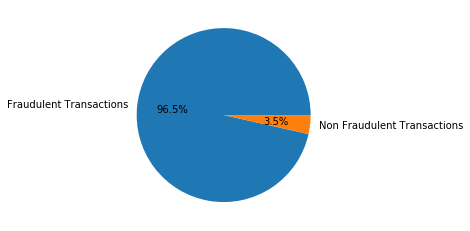

In [7]:
print("Notice that the dataset is imbalanced. Non-fraudulent transactions are a minority.")
fraudulent_transactions = dataset[dataset.isFraud==0].shape[0]
non_fraudulent_transactions = dataset[dataset.isFraud==1].shape[0]
plt.pie([fraudulent_transactions, non_fraudulent_transactions], labels=["Fraudulent Transactions", "Non Fraudulent Transactions"], autopct='%.1f%%')

In [8]:
# Note: We tried executing the code below in order to perform dopwnsampling on the majority class (fraudulent
# transactions). However, this approach did not does not improve final F1 scores, and so we decided to
# train our models with the complete dataset instead.
'''
not_fraud_downsampled = utils.resample(not_fraud, replace=False, n_samples = len(fraud), random_state = 27) 
sownsampled_dataset = pd.concat([not_fraud_downsampled, fraud])
'''

'\nnot_fraud_downsampled = utils.resample(not_fraud, replace=False, n_samples = len(fraud), random_state = 27) \nsownsampled_dataset = pd.concat([not_fraud_downsampled, fraud])\n'

In [9]:
# Fill NaN values with a default value of 0.
dataset = dataset.fillna(0)

In [10]:
# Encode labels.
for col in dataset.columns:
    if dataset[col].dtype=='object': 
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(dataset[col].values))
        dataset[col] = lbl.transform(list(dataset[col].values))

In [11]:
y = dataset.isFraud.values
dataset = dataset.drop('isFraud', axis=1)

In [12]:
# Standardize the data.
dataset_columns = list(dataset.columns)
dataset[dataset_columns] = preprocessing.StandardScaler().fit_transform(dataset[dataset_columns])

In [13]:
X_pre_pca = dataset[dataset_columns]

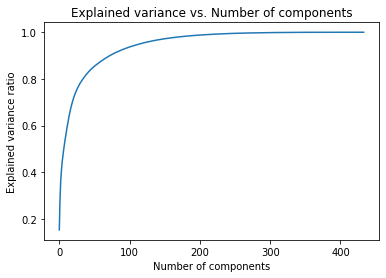

We need at least 73 to explain 90% of the variance in the dataset.


In [14]:
dataset_pca = decomposition.PCA().fit(X_pre_pca) 
cumulative_sum = np.cumsum(dataset_pca.explained_variance_ratio_)
plt.figure()
plt.plot(cumulative_sum)
plt.xlabel('Number of components')
plt.ylabel('Explained variance ratio')
plt.title('Explained variance vs. Number of components')
plt.show()

reduced_number_of_dimensions = None
for index, sum_value in enumerate(cumulative_sum):
    if sum_value > 0.9:
        reduced_number_of_dimensions = index+1
        break
print("We need at least " + str(reduced_number_of_dimensions) + " to explain 90% of the variance in the dataset.")

In [15]:
# Reduce number of dimensions through PCA. We decrease the amount of computational time required to model the data
# by reducing dimensions (notice that the transformed dataset explains at least 90% of the variance).
pca = decomposition.PCA(n_components=reduced_number_of_dimensions, random_state=42)
X_post_pca = pca.fit_transform(X_pre_pca) 
print(pca.explained_variance_ratio_.sum())

0.8995486605290798


In [16]:
# Perform 80/20 train/test split.
X_train, X_test, y_train, y_test = model_selection.train_test_split(X_post_pca, y, test_size=0.2, random_state=1)

In [31]:
# The following function returns a model with the hyperparameters that yield the best f1 score.
def get_model_with_best_estimators(model, parameters, X_train, y_train):
    grid_search = model_selection.GridSearchCV(model, parameters, scoring='f1', cv=4)
    grid_search.fit(X_train, y_train)
    # print("The best (weighted) F1 score obtained on the training dataset is: " + str(grid_search.best_score_))
    return grid_search.best_estimator_

In [32]:
# Extracted from: https://scikit-learn.org/0.18/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [33]:
# SVM model.
svm_parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
svm_model = sklearn.svm.SVC(max_iter=700)
best_svm_model = get_model_with_best_estimators(svm_model, svm_parameters, X_train, y_train)

Confusion matrix, without normalization


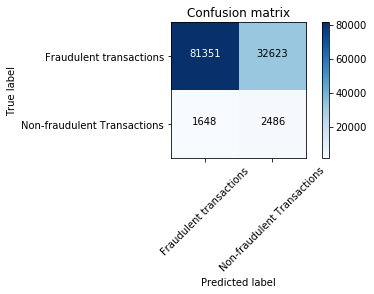

In [34]:
cf_matrix_svc = sklearn.metrics.confusion_matrix(y_test, best_svm_model.predict(X_test))
plot_confusion_matrix(cf_matrix_svc, ["Fraudulent transactions", "Non-fraudulent Transactions"])

In [35]:
print(sklearn.metrics.classification_report(y_test, best_svm_model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.98      0.71      0.83    113974
           1       0.07      0.60      0.13      4134

    accuracy                           0.71    118108
   macro avg       0.53      0.66      0.48    118108
weighted avg       0.95      0.71      0.80    118108



In [36]:
# Logistic regression model.
logistic_regression_parameters = {'C':[1, 10], 'penalty':('l2',), 'solver':('saga', 'newton-cg')}
logistic_regression = linear_model.LogisticRegression(n_jobs=-1, max_iter=700)
best_logistic_regression_model = get_model_with_best_estimators(logistic_regression, logistic_regression_parameters, X_train, y_train)

Confusion matrix, without normalization


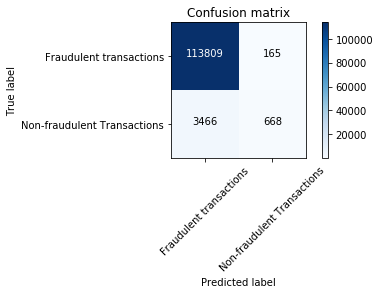

In [37]:
cf_matrix_logistic_regression = sklearn.metrics.confusion_matrix(y_test, best_logistic_regression_model.predict(X_test))
plot_confusion_matrix(cf_matrix_logistic_regression, ["Fraudulent transactions", "Non-fraudulent Transactions"])

In [38]:
print(sklearn.metrics.classification_report(y_test, best_logistic_regression_model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98    113974
           1       0.80      0.16      0.27      4134

    accuracy                           0.97    118108
   macro avg       0.89      0.58      0.63    118108
weighted avg       0.96      0.97      0.96    118108



In [39]:
# Random forest model.
random_forest_parameters = {'n_estimators':[50, 150], 'criterion':('gini', 'entropy')}
random_forest = ensemble.RandomForestClassifier(n_jobs=-1)
best_random_forest_model = get_model_with_best_estimators(random_forest, random_forest_parameters, X_train, y_train)

Confusion matrix, without normalization


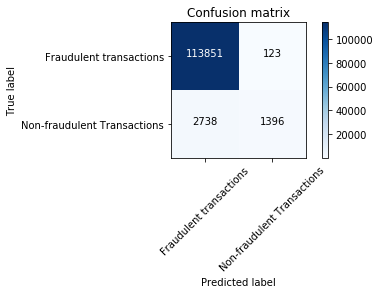

In [40]:
cf_matrix_random_forest = sklearn.metrics.confusion_matrix(y_test, best_random_forest_model.predict(X_test))
plot_confusion_matrix(cf_matrix_random_forest, ["Fraudulent transactions", "Non-fraudulent Transactions"])

In [41]:
print(sklearn.metrics.classification_report(y_test, best_random_forest_model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99    113974
           1       0.92      0.34      0.49      4134

    accuracy                           0.98    118108
   macro avg       0.95      0.67      0.74    118108
weighted avg       0.97      0.98      0.97    118108



In [42]:
def split_with_PCA(k, x_tr, y):
    X_pca = decomposition.PCA(n_components=k).fit_transform(x_tr)  
    return model_selection.train_test_split(X_pca, y, test_size=.2, random_state=1)

In [43]:
# Neural network approach.
n_cols = 300
x_tr, x_test, y_tr, y_test = split_with_PCA(300, X_pre_pca, y)
hidden_layers_neurons = [[500, 600], [300, 350], [100, 150], [40, 70]]
best_nn_model = None
best_nn_macro_f1_score = -float('inf')

In [51]:
# This function performs a "customized grid search" on the number of neurons per layer of a sequential neural network.
def evaluate_optimal_nn_model(neurons_per_hidden_layer, x_tr, x_test, y_tr, y_test, n_cols):
    cur_nn = Sequential()
    batch_size = 5000
    num_epochs = 10
    
    cur_nn.add(Dense(n_cols, activation='relu', input_shape=(n_cols,)))
    cur_nn.add(Dropout(0.2))
    cur_nn.add(Dense(neurons_per_hidden_layer[0], activation='relu'))
    cur_nn.add(Dropout(0.2))
    cur_nn.add(Dense(neurons_per_hidden_layer[1], activation='relu'))
    cur_nn.add(Dropout(0.2))
    cur_nn.add(Dense(neurons_per_hidden_layer[2], activation='relu'))
    cur_nn.add(Dropout(0.2))
    cur_nn.add(Dense(neurons_per_hidden_layer[3], activation='relu'))
    cur_nn.add(Dropout(0.2))
    cur_nn.add(Dense(1, activation='sigmoid'))
    cur_nn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', 'categorical_accuracy'])
    
    x_vl, y_vl = x_tr[:batch_size], y_tr[:batch_size]
    x_train, y_train = x_tr[batch_size:], y_tr[batch_size:]
    
    cur_nn.fit(x_train, y_train, validation_data=(x_vl, y_vl), epochs=num_epochs, batch_size=batch_size, verbose=0)
    
    print("Classification report for the following parameters (equal to number of neurons per hidden layer) = " + str(neurons_per_hidden_layer))
    cl_report = sklearn.metrics.classification_report(y_test, cur_nn.predict_classes(x_test))
    print(cl_report)
    
    macro_f1_score = sklearn.metrics.f1_score(y_test, cur_nn.predict_classes(x_test), average='macro')
    
    global best_nn_macro_f1_score, best_nn_model
    if macro_f1_score > best_nn_macro_f1_score:
        best_nn_macro_f1_score = macro_f1_score
        best_nn_model = cur_nn

In [52]:
# We pass all different combinations of number of neurons for each hidden layer in order to find the best NN model.
for combination_neurons in itertools.product(*hidden_layers_neurons):
    evaluate_optimal_nn_model(combination_neurons, x_tr, x_test, y_tr, y_test, n_cols)

Classification report for the following parameters (equal to number of neurons per hidden layer) = (500, 300, 100, 40)
              precision    recall  f1-score   support

           0       0.98      1.00      0.99    113974
           1       0.83      0.50      0.63      4134

    accuracy                           0.98    118108
   macro avg       0.91      0.75      0.81    118108
weighted avg       0.98      0.98      0.98    118108

Classification report for the following parameters (equal to number of neurons per hidden layer) = (500, 300, 100, 70)
              precision    recall  f1-score   support

           0       0.98      1.00      0.99    113974
           1       0.83      0.51      0.63      4134

    accuracy                           0.98    118108
   macro avg       0.90      0.75      0.81    118108
weighted avg       0.98      0.98      0.98    118108

Classification report for the following parameters (equal to number of neurons per hidden layer) = (500, 300

In [53]:
print("Best neural network model (in terms of highest f1 macro/unweighted score): ")
cl_report = sklearn.metrics.classification_report(y_test, best_nn_model.predict_classes(x_test))
print(cl_report)

Classification report (in terms of highest f1 macro score) for the neural network model: 
              precision    recall  f1-score   support

           0       0.98      1.00      0.99    113974
           1       0.83      0.51      0.63      4134

    accuracy                           0.98    118108
   macro avg       0.91      0.75      0.81    118108
weighted avg       0.98      0.98      0.98    118108

